# 06: Clustering metros with similar stress profiles

This notebook groups metros that look alike on the ASI stress signals. It uses two methods (KMeans and HDBSCAN) so we can see both tidy, centroid-based groups and denser clusters with outliers. Clusters are descriptive groupings, not labels of quality or performance.

This notebook:
- reloads the stress signals and ASI scores
- recomputes PCA scores for a shared coordinate system
- finds clusters with KMeans and HDBSCAN
- exports labeled metros and summary tables

## Why HDBSCAN?

KMeans forces every metro into a cluster. HDBSCAN lets some metros remain unassigned if they do not sit near any dense group. That is useful when a metro is unusually different from the rest.

Key traits:
- It finds clusters based on density, not distance to a centroid.
- It does not require choosing the number of clusters in advance.
- It can label outliers as `-1` so we can treat them as special cases.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, RobustScaler


import hdbscan


sns.set_theme(style="whitegrid")
%matplotlib inline

run_stamp = pd.Timestamp.today().strftime("%Y-%m-%d")

## Load data

Read the engineered features and ASI scores from disk and merge them by `metro_id`. This keeps the clustering run in sync with earlier notebooks.

In [2]:
features_path = Path("data/processed/features_scaled.csv")
asi_path = Path("data/processed/asi_scores.csv")
clusters_kmeans_path = Path("data/processed/clusters_kmeans.csv")
clusters_hdbscan_path = Path("data/processed/clusters_hdbscan.csv")
figures_dir = Path("report/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

feature_cols = [
    "rent_to_income_scaled",
    "rent_growth_yoy_scaled",
    "vacancy_stress_scaled",
]

features_df = pd.read_csv(features_path)
asi_df = pd.read_csv(asi_path)[["metro_id", "asi_score"]]

df = features_df.merge(asi_df, on="metro_id", how="left")
print(f"Loaded {len(df):,} metro-year records with engineered features.")
print(f"ASIs available for {df['asi_score'].notna().sum():,} rows.")
df.head()[
    [
        "metro_id",
        "metro_name_std",
        "province",
        "asi_score",
        *feature_cols,
    ]
]

Loaded 41 metro-year records with engineered features.
ASIs available for 41 rows.


,metro_id,metro_name_std,province,asi_score,rent_to_income_scaled,rent_growth_yoy_scaled,vacancy_stress_scaled
0,3932,Abbotsford-Mission,British Columbia,0.223394,NaN,0.146789,0.3
1,3568,Barrie,Ontario,-0.710092,NaN,-0.220183,-1.2
2,3522,Belleville-Quinte West,Ontario,-0.300000,NaN,NaN,-0.3
3,3543,Brantford,Ontario,-0.400000,NaN,NaN,-0.4
4,3825,Calgary,Alberta,-1.109979,-0.319959,NaN,-1.9


## Prepare data for clustering

We drop rows missing any of the three scaled stress signals, standardize them again, and run PCA to get PC1 to PC3. These PCA coordinates are used for all clustering and plots.

In [3]:
complete = df.dropna(subset=feature_cols).copy()
print(f"Complete cases for clustering: {len(complete):,}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(complete[feature_cols])

pca = PCA(n_components=min(3, X_scaled.shape[1]))
pcs = pca.fit_transform(X_scaled)
pc_cols = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]
complete[pc_cols] = pcs
explained = pca.explained_variance_ratio_
print("Explained variance ratios:", np.round(explained, 3))

complete[["metro_name_std", *pc_cols]].head()

Complete cases for clustering: 18
Explained variance ratios: [0.599 0.255 0.146]


,metro_name_std,PC1,PC2,PC3
7,Edmonton,-0.382797,-1.595493,-0.429924
11,Halifax,0.676198,1.470781,0.092504
12,Hamilton,-1.205933,-0.990340,0.524700
16,Kitchener-Cambridge-Waterloo,-1.497680,-0.440905,-0.606745
18,London,-1.652555,0.664034,-0.652701


## Determine the number of clusters (KMeans)

We try K from 2 to 10 and measure two diagnostics:
- Inertia: how tight the clusters are.
- Silhouette: how well-separated the clusters are.

This gives a transparent reason for the chosen K.

In [4]:
k_values = range(2, 11)
results = []
X_pca = complete[pc_cols].values

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=25)
    labels = model.fit_predict(X_pca)
    inertia = model.inertia_
    silhouette = silhouette_score(X_pca, labels)
    results.append({
        "k": k,
        "inertia": inertia,
        "silhouette": silhouette,
    })

k_sweep_df = pd.DataFrame(results)
k_sweep_df

,k,inertia,silhouette
0,2,30.013362,0.351132
1,3,20.160471,0.338112
2,4,15.343863,0.304433
3,5,13.032067,0.235270
4,6,10.384554,0.227626
5,7,9.017202,0.220984
6,8,7.647817,0.155005
7,9,6.215805,0.154730
8,10,4.800716,0.156972


PosixPath('report/figures/kmeans_k_sweep.png')

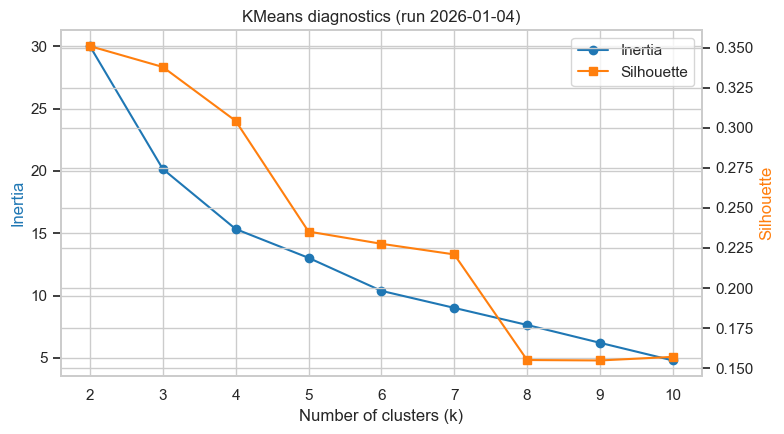

In [5]:
fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

ax1.plot(k_sweep_df["k"], k_sweep_df["inertia"], marker="o", color="#1f77b4", label="Inertia")
ax2.plot(k_sweep_df["k"], k_sweep_df["silhouette"], marker="s", color="#ff7f0e", label="Silhouette")

ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Inertia", color="#1f77b4")
ax2.set_ylabel("Silhouette", color="#ff7f0e")
ax1.set_title(f"KMeans diagnostics (run {run_stamp})")

lines = [
    plt.Line2D([0], [0], color="#1f77b4", marker="o", label="Inertia"),
    plt.Line2D([0], [0], color="#ff7f0e", marker="s", label="Silhouette"),
]
ax1.legend(handles=lines, loc="upper right")
fig.tight_layout()

sweep_plot_path = figures_dir / "kmeans_k_sweep.png"
fig.savefig(sweep_plot_path, dpi=200)
sweep_plot_path

## Choose K and fit final model

We pick the K with the best silhouette score (ties broken by the first value) and fit the final KMeans model. This produces cluster labels like C1, C2, and so on.

In [6]:
best_row = k_sweep_df.loc[k_sweep_df["silhouette"].idxmax()]
final_k = int(best_row["k"])
print(
    f"Peak silhouette at k={final_k} (silhouette={best_row['silhouette']:.3f}, inertia={best_row['inertia']:.1f})."
)

kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(X_pca)
complete["cluster_kmeans"] = cluster_labels
complete["cluster_label"] = complete["cluster_kmeans"].apply(lambda x: f"C{x + 1}")

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=pc_cols)
centroids["cluster_label"] = [f"C{i + 1}" for i in range(final_k)]
centroids

Peak silhouette at k=2 (silhouette=0.351, inertia=30.0).


,PC1,PC2,PC3,cluster_label
0,1.610038,0.264930,0.052652,C1
1,-0.805019,-0.132465,-0.026326,C2


## Visualize clusters

Plot PC1 vs PC2 with colors for each cluster. This helps us see how the groups relate to the main stress signals.

PosixPath('report/figures/pca_clusters_kmeans.png')

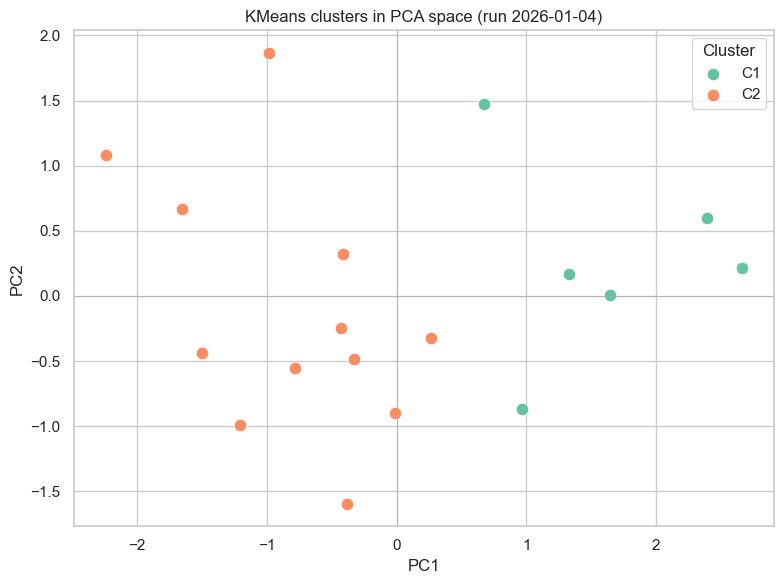

In [7]:
palette = sns.color_palette("Set2", n_colors=final_k)
cluster_colors = {label: palette[idx] for idx, label in enumerate(sorted(complete["cluster_label"].unique()))}

fig, ax = plt.subplots(figsize=(8, 6))
for label, subset in complete.groupby("cluster_label"):
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        s=80,
        label=label,
        color=cluster_colors[label],
        edgecolor="white",
        linewidth=0.5,
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"KMeans clusters in PCA space (run {run_stamp})")
ax.axhline(0, color="#aaaaaa", linewidth=0.5)
ax.axvline(0, color="#aaaaaa", linewidth=0.5)
ax.legend(title="Cluster")
fig.tight_layout()

scatter_path = figures_dir / "pca_clusters_kmeans.png"
fig.savefig(scatter_path, dpi=200)
scatter_path

## Analyze cluster characteristics

We summarize each cluster with simple stats and a short list of example metros so the groups are easy to interpret.

In [8]:
cluster_summary = (
    complete.groupby("cluster_label")
    .agg(
        n_metros=("metro_id", "count"),
        asi_mean=("asi_score", "mean"),
        rent_to_income_scaled=("rent_to_income_scaled", "mean"),
        rent_growth_yoy_scaled=("rent_growth_yoy_scaled", "mean"),
        vacancy_stress_scaled=("vacancy_stress_scaled", "mean"),
        PC1_mean=("PC1", "mean"),
        PC2_mean=("PC2", "mean"),
        PC3_mean=("PC3", "mean"),
    )
    .round(3)
)
cluster_summary

,n_metros,asi_mean,rent_to_income_scaled,rent_growth_yoy_scaled,vacancy_stress_scaled,PC1_mean,PC2_mean,PC3_mean
cluster_label,,,,,,,,
C1,6,0.383,-0.130,0.746,0.533,1.610,0.265,0.053
C2,12,-0.102,0.614,-0.469,-0.450,-0.805,-0.132,-0.026


In [9]:
cluster_examples = (
    complete.groupby("cluster_label")["metro_name_std"]
    .apply(lambda names: ", ".join(sorted(names)[:5]) + (" …" if len(names) > 5 else ""))
)
cluster_examples

cluster_label
C1      Halifax, Montréal, Québec, Regina, Sherbrooke …
C2    Edmonton, Hamilton, Kitchener-Cambridge-Waterl...
Name: metro_name_std, dtype: object

## Export results

Save the labeled metros to `data/processed/clusters_kmeans.csv` so other notebooks or dashboards can use them.

In [10]:
export_cols = [
    "metro_id",
    "metro_name_std",
    "province",
    "asi_score",
    *feature_cols,
    *pc_cols,
    "cluster_kmeans",
    "cluster_label",
]

clusters_output = complete[export_cols].sort_values("cluster_kmeans").reset_index(drop=True)
clusters_output.to_csv(clusters_kmeans_path, index=False)
clusters_kmeans_path

PosixPath('data/processed/clusters_kmeans.csv')

### Notes

- The KMeans sweep diagnostics are stored in `k_sweep_df`.
- Key artifacts: `report/figures/kmeans_k_sweep.png`, `report/figures/pca_clusters_kmeans.png`, and `data/processed/clusters_kmeans.csv`.
- HDBSCAN outputs are listed later in this notebook.

## HDBSCAN parameter sweep

We vary `min_cluster_size` and `min_samples` to see how many clusters appear and how many metros are labeled as noise. This helps choose stable settings.

In [11]:
min_cluster_sizes = [3, 4, 5, 6]
min_samples_values = [1, 2, 3, 4]

sweep_records = []
X_input = complete[pc_cols].values

for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            metric="euclidean",
            gen_min_span_tree=True,
        )
        labels = clusterer.fit_predict(X_input)
        n_clusters = len(set(labels) - {-1})
        noise_frac = float((labels == -1).mean())

        sil = np.nan
        mask = labels != -1
        if mask.sum() >= 2 and len(np.unique(labels[mask])) > 1:
            sil = silhouette_score(X_input[mask], labels[mask])

        sweep_records.append(
            {
                "min_cluster_size": mcs,
                "min_samples": ms,
                "n_clusters": n_clusters,
                "noise_frac": round(noise_frac, 3),
                "silhouette": None if np.isnan(sil) else round(float(sil), 3),
                "relative_validity": round(float(clusterer.relative_validity_), 3),
            }
        )

hdbscan_sweep_df = (
    pd.DataFrame(sweep_records)
    .sort_values(["n_clusters", "relative_validity", "noise_frac"], ascending=[False, False, True])
    .reset_index(drop=True)
)
hdbscan_sweep_df

,min_cluster_size,min_samples,n_clusters,noise_frac,silhouette,relative_validity
0,3,1,2,0.333,0.449,0.034
1,4,1,2,0.333,0.449,0.034
2,3,2,0,1.000,NaN,0.000
3,3,3,0,1.000,NaN,0.000
4,3,4,0,1.000,NaN,0.000
5,4,2,0,1.000,NaN,0.000
6,4,3,0,1.000,NaN,0.000
7,4,4,0,1.000,NaN,0.000
8,5,1,0,1.000,NaN,0.000
9,5,2,0,1.000,NaN,0.000


## Select HDBSCAN parameters

We pick a setting that produces at least two clusters, keeps the noise share reasonable, and scores well on HDBSCAN's stability metric.

In [12]:
candidates = hdbscan_sweep_df[
    (hdbscan_sweep_df["n_clusters"] >= 2) & (hdbscan_sweep_df["noise_frac"] <= 0.4)
]
if candidates.empty:
    candidates = hdbscan_sweep_df[hdbscan_sweep_df["n_clusters"] >= 1]

best_hdbscan_row = candidates.sort_values(
    ["relative_validity", "silhouette"], ascending=[False, False]
).iloc[0]

hdbscan_params = {
    "min_cluster_size": int(best_hdbscan_row["min_cluster_size"]),
    "min_samples": int(best_hdbscan_row["min_samples"]),
}
print("Selected HDBSCAN parameters:", hdbscan_params)
print(
    f"n_clusters={int(best_hdbscan_row['n_clusters'])}, noise_frac={best_hdbscan_row['noise_frac']}, "
    f"relative_validity={best_hdbscan_row['relative_validity']}, silhouette={best_hdbscan_row['silhouette']}"
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=hdbscan_params["min_cluster_size"],
    min_samples=hdbscan_params["min_samples"],
    metric="euclidean",
    gen_min_span_tree=True,
)
hdbscan_labels = hdbscan_model.fit_predict(X_input)
probabilities = hdbscan_model.probabilities_

complete["cluster_hdbscan"] = hdbscan_labels
label_map = {}
cluster_ids = sorted([label for label in np.unique(hdbscan_labels) if label != -1])
for idx, cid in enumerate(cluster_ids, start=1):
    label_map[cid] = f"H{idx}"

complete["cluster_hdbscan_label"] = [
    label_map.get(label, "noise") for label in hdbscan_labels
]
complete["cluster_hdbscan_prob"] = probabilities

pd.Series(complete["cluster_hdbscan_label"].value_counts())

Selected HDBSCAN parameters: {'min_cluster_size': 3, 'min_samples': 1}
n_clusters=2, noise_frac=0.333, relative_validity=0.034, silhouette=0.449


cluster_hdbscan_label
H2       8
noise    6
H1       4
Name: count, dtype: int64

## Visualize HDBSCAN assignments

Plot PC1 vs PC2 again, coloring clusters and shading noise points in light gray.

PosixPath('report/figures/pca_clusters_hdbscan.png')

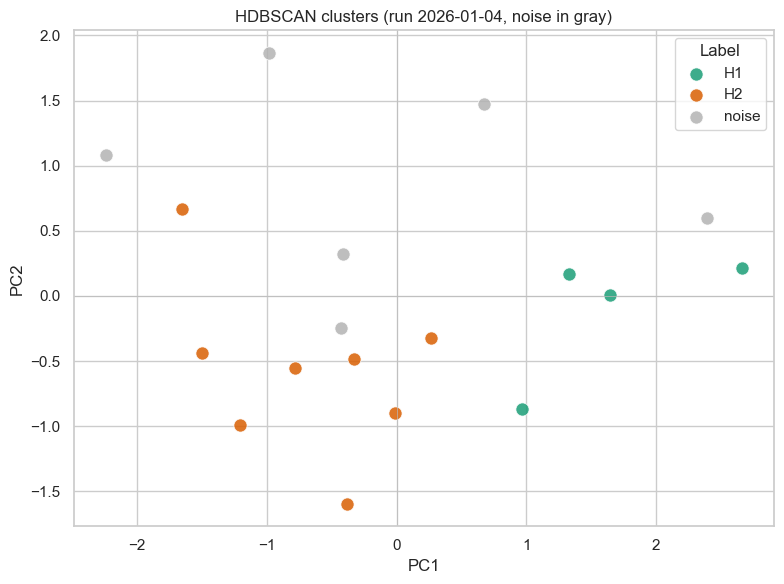

In [13]:
unique_labels = sorted(complete["cluster_hdbscan_label"].unique())
colors = sns.color_palette("Dark2", n_colors=max(1, len(unique_labels) - ("noise" in unique_labels)))
color_map = {}
color_idx = 0
for label in unique_labels:
    if label == "noise":
        color_map[label] = (0.7, 0.7, 0.7)
    else:
        color_map[label] = colors[color_idx]
        color_idx += 1

fig, ax = plt.subplots(figsize=(8, 6))
for label, subset in complete.groupby("cluster_hdbscan_label"):
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        s=90,
        color=color_map[label],
        edgecolor="white",
        linewidth=0.6,
        alpha=0.85,
        label=label,
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"HDBSCAN clusters (run {run_stamp}, noise in gray)")
ax.axhline(0, color="#bbbbbb", linewidth=0.5)
ax.axvline(0, color="#bbbbbb", linewidth=0.5)
ax.legend(title="Label")
fig.tight_layout()

hdbscan_scatter_path = figures_dir / "pca_clusters_hdbscan.png"
fig.savefig(hdbscan_scatter_path, dpi=200)
hdbscan_scatter_path

## Noise / outlier metros

List the metros labeled as noise (`-1`). These are places that do not fit neatly into any dense group.

These metros sit far from other metros in PCA space. Treating them as outliers keeps the cluster stories cleaner and avoids forcing a poor fit.

## Export HDBSCAN results

Save the density-based labels to `data/processed/clusters_hdbscan.csv`.

In [14]:
hdbscan_export_cols = [
    "metro_id",
    "metro_name_std",
    "province",
    "asi_score",
    *feature_cols,
    *pc_cols,
    "cluster_hdbscan",
    "cluster_hdbscan_label",
    "cluster_hdbscan_prob",
]

clusters_hdbscan_output = (
    complete[hdbscan_export_cols]
    .sort_values(["cluster_hdbscan_label", "cluster_hdbscan_prob"], ascending=[True, False])
    .reset_index(drop=True)
)
clusters_hdbscan_output.to_csv(clusters_hdbscan_path, index=False)
clusters_hdbscan_path

PosixPath('data/processed/clusters_hdbscan.csv')

In [15]:
noise_rows = complete[complete["cluster_hdbscan_label"] == "noise"].copy()
if noise_rows.empty:
    print("No metros labeled as noise at the selected HDBSCAN parameters.")
else:
    display(
        noise_rows[
            [
                "metro_name_std",
                "province",
                "asi_score",
                "PC1",
                "PC2",
                "cluster_hdbscan_prob",
            ]
        ].sort_values("cluster_hdbscan_prob")
    )

,metro_name_std,province,asi_score,PC1,PC2,cluster_hdbscan_prob
11,Halifax,Nova Scotia,0.773185,0.676198,1.470781,0.0
31,Sherbrooke,Quebec,0.633648,2.392280,0.597277,0.0
35,Toronto,Ontario,0.139322,-0.409472,0.323621,0.0
37,Vancouver,British Columbia,0.223559,-2.239087,1.081620,0.0
38,Victoria,British Columbia,0.724504,-0.979706,1.865491,0.0
40,Winnipeg,Manitoba,-0.108370,-0.428704,-0.243641,0.0


## Cluster profiles and personas

Translate raw cluster labels into personas by summarizing the stress signals (medians + IQRs), flagging exemplar metros, and rendering heatmaps that can be dropped straight into the final report. These profiles cover both the KMeans clusters and the HDBSCAN labels (including `noise`).

**Heatmap values**: Each number is the cluster median of the scaled feature (from `data/processed/features_scaled.csv`). 
Scaling is robust: `(value - overall median) / IQR`, so `0` is the typical metro, `+1` is one IQR above the median (more stress), and `-1` is one IQR below (less stress). 
Vacancy stress is the inverted vacancy rate, so higher values mean tighter markets.


In [16]:
feature_pretty = {
    "rent_to_income_scaled": "Rent-to-income",
    "rent_growth_yoy_scaled": "Rent growth",
    "vacancy_stress_scaled": "Vacancy stress",
}

cluster_profiles_path = Path("data/processed/cluster_profiles.csv")


def summarize_profiles(data, label_col, method_name):
    global_medians = data[feature_cols].median()
    records = []

    for label, subset in data.groupby(label_col):
        medians = subset[feature_cols].median()
        iqrs = subset[feature_cols].quantile(0.75) - subset[feature_cols].quantile(0.25)
        exemplars = ", ".join(sorted(subset["metro_name_std"])[:3])

        high = [feature_pretty[col] for col in feature_cols if medians[col] - global_medians[col] >= 0.4]
        low = [feature_pretty[col] for col in feature_cols if medians[col] - global_medians[col] <= -0.4]
        story_bits = []
        if high:
            story_bits.append(f"Above-average {', '.join(high)}")
        if low:
            story_bits.append(f"Relief on {', '.join(low)}")
        if not story_bits:
            story_bits.append("Balanced across signals")

        record = {
            "method": method_name,
            "cluster_label": label,
            "n_metros": int(len(subset)),
            "asi_median": round(subset["asi_score"].median(), 3),
            "exemplar_metros": exemplars,
            "narrative": "; ".join(story_bits),
        }

        for col in feature_cols:
            record[f"{col}_median"] = round(medians[col], 3)
            record[f"{col}_iqr"] = round(iqrs[col], 3)

        records.append(record)

    return (
        pd.DataFrame(records)
        .sort_values("cluster_label")
        .reset_index(drop=True)
    )


def plot_profile_heatmap(profiles_df, method_name):
    heatmap_df = profiles_df.set_index("cluster_label")[
        [f"{col}_median" for col in feature_cols]
    ].rename(columns={f"{col}_median": feature_pretty[col] for col in feature_cols})

    fig, ax = plt.subplots(figsize=(6, 0.8 * len(heatmap_df) + 1.5))
    sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="RdYlBu_r", center=0, ax=ax)
    ax.set_title(f"Cluster profiles ({method_name.upper()}, run {run_stamp})")
    ax.set_xlabel("Signal (median)")
    ax.set_ylabel("Cluster")
    fig.tight_layout()

    out_path = figures_dir / f"cluster_profiles_{method_name}.png"
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    return out_path

In [17]:
kmeans_profiles = summarize_profiles(complete, "cluster_label", "kmeans")
hdbscan_profiles = summarize_profiles(complete, "cluster_hdbscan_label", "hdbscan")

pd.concat(
    {
        "KMeans": kmeans_profiles,
        "HDBSCAN": hdbscan_profiles,
    },
    names=["method"],
)


method cluster_label  n_metros  asi_median  \
method                                                   
KMeans  0   kmeans            C1         6       0.402   
        1   kmeans            C2        12      -0.145   
HDBSCAN 0  hdbscan            H1         4       0.292   
        1  hdbscan            H2         8      -0.299   
        2  hdbscan         noise         6       0.429   

                                            exemplar_metros  \
method                                                        
KMeans  0                         Halifax, Montréal, Québec   
        1  Edmonton, Hamilton, Kitchener-Cambridge-Waterloo   
HDBSCAN 0                          Montréal, Québec, Regina   
        1  Edmonton, Hamilton, Kitchener-Cambridge-Waterloo   
        2                      Halifax, Sherbrooke, Toronto   

                                                   narrative  \
method                                                         
KMeans  0          Above-average Rent growth, Vacancy stress   
        1                            Balanced across signals   
HDBSCAN 0  Above-average Rent growth, Vacancy stress; Rel...   
        1                           Relief on Vacancy stress   
        2                       Above-average Rent-to-income   

           rent_to_income_scaled_median  rent_to_income_scaled_iqr  \
method                                                               
KMeans  0                        -0.304                      0.364   
        1                         0.361                      1.030   
HDBSCAN 0                        -0.457                      0.363   
        1                         0.089                      0.455   
        2                         1.064                      1.437   

           rent_growth_yoy_scaled_median  rent_growth_yoy_scaled_iqr  \
method                                                                 
KMeans  0                          0.752                       0.459   
        1                         -0.495                       0.486   
HDBSCAN 0                          0.642                       0.615   
        1                         -0.394                       0.339   
        2                         -0.239                       1.394   

           vacancy_stress_scaled_median  vacancy_stress_scaled_iqr  
method                                                              
KMeans  0                          0.40                      0.225  
        1                         -0.55                      0.525  
HDBSCAN 0                          0.55                      0.450  
        1                         -0.65                      0.375  
        2                          0.20                      0.500

In [18]:
kmeans_profiles_fig = plot_profile_heatmap(kmeans_profiles, "kmeans")
hdbscan_profiles_fig = plot_profile_heatmap(hdbscan_profiles, "hdbscan")
[kmeans_profiles_fig, hdbscan_profiles_fig]

[PosixPath('report/figures/cluster_profiles_kmeans.png'),
 PosixPath('report/figures/cluster_profiles_hdbscan.png')]

In [19]:
cluster_profiles_df = pd.concat([kmeans_profiles, hdbscan_profiles], ignore_index=True)
cluster_profiles_df.to_csv(cluster_profiles_path, index=False)
cluster_profiles_path

PosixPath('data/processed/cluster_profiles.csv')

*Artifacts saved: `report/figures/cluster_profiles_kmeans.png`, `report/figures/cluster_profiles_hdbscan.png`, and `data/processed/cluster_profiles.csv`.*

## Robustness checks: scaling and feature sensitivity

We rerun KMeans under small changes to see how stable the clusters are:
1. Use a robust scaler instead of the standard scaler.
2. Drop one stress signal at a time.

We then compare cluster assignments with the Adjusted Rand Index (ARI). This tells us whether the clustering is sensitive to preprocessing choices.

In [20]:
def evaluate_variant(feature_subset, scaler_cls, variant_name):
    variant_df = df.dropna(subset=feature_subset).copy()
    scaler = scaler_cls()
    X_variant = scaler.fit_transform(variant_df[feature_subset])
    pca_variant = PCA(n_components=min(3, X_variant.shape[1]))
    pcs_variant = pca_variant.fit_transform(X_variant)

    model = KMeans(n_clusters=final_k, random_state=42, n_init=50)
    variant_labels = model.fit_predict(pcs_variant)
    variant_df["cluster_variant"] = variant_labels

    overlap = variant_df.merge(
        complete[["metro_id", "cluster_kmeans"]],
        on="metro_id",
        how="inner",
    )

    ari = np.nan
    if len(overlap) >= 2:
        ari = adjusted_rand_score(overlap["cluster_kmeans"], overlap["cluster_variant"])

    coverage = len(overlap) / len(complete) if len(complete) else np.nan

    return {
        "variant": variant_name,
        "features_used": ", ".join(feature_subset),
        "scaler": scaler_cls.__name__,
        "n_overlap": int(len(overlap)),
        "coverage": None if np.isnan(coverage) else round(float(coverage), 3),
        "ari": None if np.isnan(ari) else round(float(ari), 3),
    }


sensitivity_records = []

# 1) Alternate scaler (RobustScaler)
sensitivity_records.append(
    evaluate_variant(feature_cols, RobustScaler, "All features + RobustScaler")
)

# 2) Leave-one-feature-out tests
for col in feature_cols:
    subset = [c for c in feature_cols if c != col]
    sensitivity_records.append(
        evaluate_variant(subset, StandardScaler, f"Drop {col}")
    )

sensitivity_results = pd.DataFrame(sensitivity_records)
sensitivity_results

,variant,features_used,scaler,n_overlap,coverage,ari
0,All features + RobustScaler,"rent_to_income_scaled, rent_growth_yoy_scaled,...",RobustScaler,18,1.0,1.000
1,Drop rent_to_income_scaled,"rent_growth_yoy_scaled, vacancy_stress_scaled",StandardScaler,18,1.0,0.776
2,Drop rent_growth_yoy_scaled,"rent_to_income_scaled, vacancy_stress_scaled",StandardScaler,18,1.0,-0.049
3,Drop vacancy_stress_scaled,"rent_to_income_scaled, rent_growth_yoy_scaled",StandardScaler,18,1.0,0.153


### Interpreting the sensitivity table

- ARI near 1.0: clusters are very similar to the baseline.
- ARI near 0: clusters change a lot, so the grouping is fragile.
- Coverage: the share of metros present in both runs.

These checks do not change the ASI itself. They only test how clustering responds to preprocessing changes.

## Limitations

- We only re-check KMeans here; HDBSCAN would need its own sensitivity sweep.
- We hold K constant to isolate preprocessing effects, so we do not test whether K should change.
- PCA is recomputed each time, so axis directions are not directly comparable across variants.
- If a variant drops many metros, the stability score reflects a smaller sample.
- These checks do not recompute ASI; they only test clustering stability.